### Use the neuralflow kernel
I installed the package with the multi-condition potential and tuning curve optimization in the kernel above

In [1]:
# Import packages 
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec

# my import
#import scipy
import os
from datetime import datetime
import pickle
import random


In [2]:
# folders for plots and general parameters

plots_dir="./../plot/testing/"

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# general parameters
plot_ext = ".jpg"


In [3]:
# FUNCTION "type_simul": to select the type of simulation
def type_simul(name_simul):
    ''' 
    Function to select the type of simulation and related parameters. 
    All the information are depending on the name of the simulation.
    The lengths to cut can be changed wrt which snippet you want to analyze.
    new_simul: boolean, if True it means that the simulation is in seconds, otherwise in ms.
    '''
    if name_simul == "Jp1_60":
        new_simul = False
        path_data = f'./../data/poster_data/IN_MS_For_Teo_{name_simul}'
        input_data = '/ext_input_coh80_lenS_1000TR0.npy'
        first_prefix_part = 'neurs_raster1_2_In_coh'
        last_prefix_part = '_lenS_1000TR'
        start_to_cut = 7000
        end_to_cut = 5000
        end_trial = 15000
    elif name_simul == "Jp1_65":
        new_simul = False
        path_data = f'./../data/poster_data/IN_MS_For_Teo_{name_simul}'
        input_data = '/ext_input_coh80_lenS_1000TR0.npy'
        first_prefix_part = 'neurs_raster1_2_In_coh'
        last_prefix_part = '_lenS_1000TR'
        start_to_cut = 7000
        end_to_cut = 5000
        end_trial = 15000
    elif name_simul == "Jp1_7":
        new_simul = False
        path_data = f'./../data/poster_data/IN_MS_For_Teo_{name_simul}'
        input_data = '/ext_input_coh80_lenS_1000TR0.npy'
        first_prefix_part = 'neurs_raster1_2_In_coh'
        last_prefix_part = '_lenS_1000TR'
        start_to_cut = 7000
        end_to_cut = 5000
        end_trial = 15000

    return new_simul, path_data, input_data, first_prefix_part, last_prefix_part, end_trial, start_to_cut, end_to_cut
        

In [4]:
# FUNCTION "load_trials": to load the trials

def load_trials(path, prefix_list, input, num_trials, shuffle=False):
    '''
    paht: path to the folder where the trials are stored (relative to the current working directory)
    prefix_list: prefix of the file names (list with the number of trial types)
    input: string with the name of the input file (they are all the same)
    num_trials: number of trials of each type
    shuffle: boolean to shuffle the trials or not
    '''
    trials_per_type = 100 # known value of number of trials per type

    # List all files in the folder
    all_files = os.listdir(path)

    # Filter files that start with the specified string
    filtered_files = [f for f in all_files if any(f.startswith(prefix) for prefix in prefix_list)]

    # Sort the filtered files to ensure they are in order
    filtered_files.sort()
    print(f"filtered_files: {filtered_files}")
    # Load the files and save them in a list
    all_trial_list = [np.load(os.path.join(path, file), allow_pickle=True) for file in filtered_files]
    print(f"all_trial_list: {all_trial_list}")
    data_list = []

    for i in range(len(prefix_list)):
        indices_pre_shuffle = np.arange(num_trials) + i * trials_per_type
        #print(f"indices_pre_shuffle: {indices_pre_shuffle}")
        if shuffle:
            np.random.shuffle(indices_pre_shuffle)

        # Use the list directly here
        data_list.append([all_trial_list[idx] for idx in indices_pre_shuffle])

    # Flatten the list to combine all trials
    flattened_list = [item for sublist in data_list for item in sublist]

    # Load the input data to for the raster plot
    input_data = np.load(path + input, allow_pickle=True)
    num_type_trials = len(prefix_list)

    return flattened_list, input_data, num_type_trials

In [5]:
# FUNCTION "process_trials": to process the trials
def process_trials(change_neurons, neur_to_keep, start_to_cut, end_to_cut, end_trial, data_list):
    ''' 
    change_neurons = how many indices to add to select different neurons
    neur_to_keep: number of neurons to keep
    start_to_cut = from which index to start cutting the data
    end_to_cut = how many indices to cut from the end
    end_trial = end of the trial
    data_list = list with the trials 
    dict_data_dir = directory to save the processed data
    new_simul = if the simulation is new or not, change from ms to s

    OUTPUT: dictionary with the processed data
    dictionary with a key for each trial: dict_data[trial_i] 
    each key: list with the 3 populations of neurons
    each population: array of N neurons
    each neuron: array of the spikes times
    '''

    dict_data = {}
    len_trial = end_trial - (end_to_cut + start_to_cut)
    
    for i, trial in enumerate(data_list):
        pop_1 = np.zeros((neur_to_keep), dtype=object)
        pop_2 = np.zeros((neur_to_keep), dtype=object)
        pop_I = np.zeros((neur_to_keep), dtype=object)
        pops = [pop_1, pop_2, pop_I]
        
        for pop, pop_data in zip(pops, trial.values()): 
            for neur in range(neur_to_keep):
                idx = (pop_data[neur+change_neurons] > start_to_cut) & (pop_data[neur+change_neurons] < end_trial - end_to_cut)
                pop[neur] = pop_data[neur+change_neurons][idx] - start_to_cut
        dict_data[f"trial_{i}"] = pops
    
    return dict_data, len_trial

In [6]:
# FUNCTION "plot_raster_with_input": to plot the raster with input

def plot_raster_with_input(name_simul, change_neurons, neur_to_keep, n_trials, dict_data, trial_to_plot, len_trial, input_data, start_to_cut, end_to_cut, end_trial, plot_data_for_run, plot_ext):

    """
    Plots raster data for neuron populations and input over a specified trial.

    Parameters:
        dict_data (dict): Dictionary containing trial data for each population.
        trial_to_plot (str): Key for the trial to plot (e.g., 'trial_2').
        len_trial (int): Length of the trial in time steps.
        input_data (np.array): Array of input data to plot.
        start_to_cut (int): Start index for data truncation.
        end_to_cut (int): End index for data truncation.
        end_trial (int): End of the trial.
        num_type_trials (int): Number of trial types for saving plot names.
        plots_raw_data (str): Path to save the plot.
        plot_ext (str): Extension format for saved plot (e.g., '.jpg').

    Returns:
        None: Displays and saves the plot.
    """
    
    start_to_cut = int(start_to_cut)
    end_to_cut = int(end_to_cut)
    len_input = end_trial - (end_to_cut + start_to_cut)

    # Create a figure and subplots for each population and input
    fig, axs = plt.subplots(4, 1, figsize=(10, 7))
    fig.suptitle('Raster plot neurons and input')

    # Plot neuron population rasters
    axs[0].eventplot(dict_data[trial_to_plot][0][:])
    axs[0].set_title('Pop 1')
    axs[0].set_xlim([0, len_trial])

    axs[1].eventplot(dict_data[trial_to_plot][1][:])
    axs[1].set_title('Pop 2')
    axs[1].set_xlim([0, len_trial])

    axs[2].eventplot(dict_data[trial_to_plot][2][:])
    axs[2].set_title('Pop I')
    axs[2].set_xlim([0, len_trial])

    # Plot input data
    axs[3].plot(input_data[start_to_cut:start_to_cut+len_input, 0])
    axs[3].set_title('Input')
    axs[3].set_xlim([0, len_input])
    axs[3].set_xlabel("Time (ms)")

    # Adjust subplot spacing and save figure
    plt.tight_layout()

    fig.savefig(plot_data_for_run + f'/{name_simul}_raster_plot_with_input_neurons={neur_to_keep}_change_neurons={change_neurons}_trials={n_trials}{plot_ext}')
    plt.show()


filtered_files: ['neurs_raster1_2_In_coh80_lenS_1000TR0.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR1.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR10.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR11.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR12.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR13.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR14.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR15.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR16.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR17.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR18.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR19.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR2.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR20.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR21.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR22.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR23.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR24.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR25.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR26.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR27.npz', 'neurs_raster1_2_In_

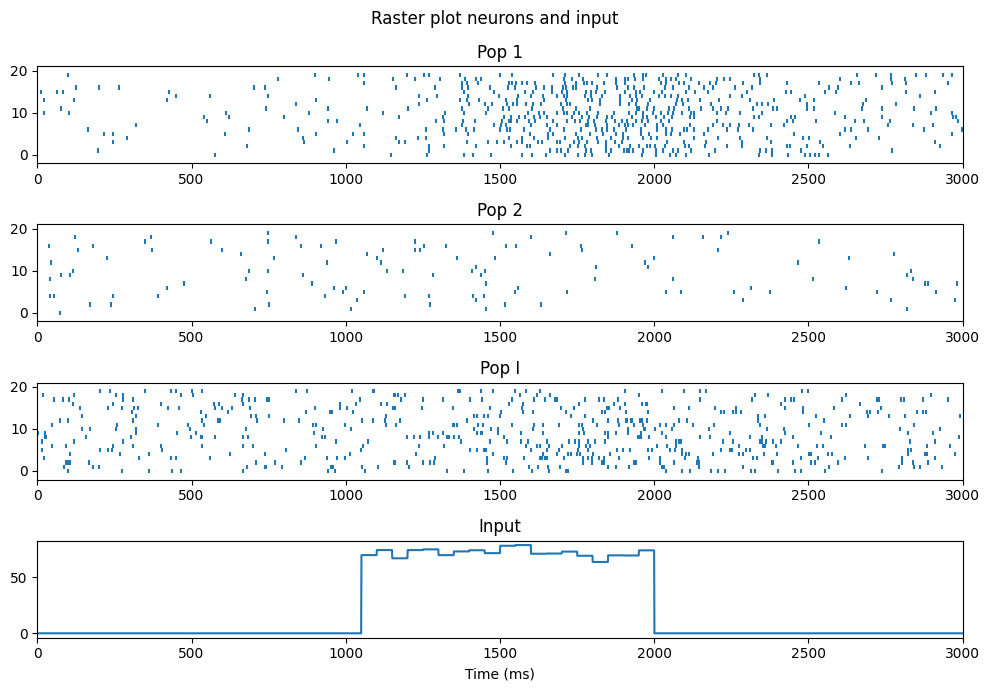

In [7]:
# CELL 1 - to make the raster plot with input

# TODO: make a single cell with everything. Put this outside the loop

# load the data: number of trials and type of trials
name_simul = "Jp1_65" #"Jp1_60", "Jp1_65", "Jp1_7", "Jp1_75", "Jp1_80"
new_simul, path_data, input_data, first_prefix_part, last_prefix_part, end_trial, start_to_cut, end_to_cut = type_simul(name_simul)
n_trials = 10 # number of trials of each type
change_neurons = 0 # when equal 0 means no change. If you want to change all the neurons, change to something > neur_to_keep
neur_to_keep = 20 # number of neurons to keep
coherence_plot = [80] # coherence of the trials to plot
prefix_list = []

# create the folder with the dataset for the inference of the model
plot_data_for_run = plots_dir + f'dataset_{name_simul}_start={start_to_cut}_end={end_trial - end_to_cut}/'
if not os.path.exists(plot_data_for_run):
    os.makedirs(plot_data_for_run)

# loop to create the prefix list to load the trials of the corresponding coherence
for coher in range(len(coherence_plot)):
    prefix_list.append(first_prefix_part + f'{coherence_plot[coher]}' + last_prefix_part)

# load the trials and process them
data_list, input_data, num_type_trials = load_trials(path_data, prefix_list, input_data, n_trials, shuffle=False)
dict_data, len_trial = process_trials(change_neurons, neur_to_keep, start_to_cut, end_to_cut, end_trial, data_list)

# plot the raster with input
trial_to_plot = 'trial_7' 
plot_raster_with_input(
    name_simul = name_simul,
    change_neurons = change_neurons,
    neur_to_keep = neur_to_keep,
    n_trials = n_trials,
    dict_data=dict_data,
    trial_to_plot=trial_to_plot,
    len_trial=len_trial,
    input_data=input_data,
    start_to_cut=start_to_cut,
    end_to_cut=end_to_cut,
    end_trial=end_trial,
    plot_data_for_run=plot_data_for_run,
    plot_ext=plot_ext
)

In [8]:
# FUNCTION "structure_data_for_model": to create the input data for the model

def structure_data_for_model(n_pop, neur_to_keep, end_trials, dict_data, dt):
    '''
    n_trials: number of trials to use per type of trials  ### Delete
    n_pop: number of populations
    neur_to_keep: number of neurons to keep per population
    end_trials: end of the trials
    dict_data: dictionary with the data
    dt: rescaling factor to match the model time step (?still need to underatnd properly why this is needed)
    '''
    # create the object array to store the spike times for each neuron and trial
    spikes = np.empty((neur_to_keep*n_pop, len(dict_data)), dtype = object)

    # loop for each neuron and trial to store the spike times form the dictionary 
    # iteration over trials
    for t,trial in enumerate(list(dict_data.keys())):
        # iteration over the different populations
        for pop in range(n_pop):
            # iteration over the neurons in each population
            for neur in range(neur_to_keep): 
                # assign the spike of the neuron of the population in the trial to the object array       
                spikes[pop*len(dict_data[trial][pop])+neur,t] = dict_data[trial][pop][neur] 
                #print(f"iteration check neurons {dict_data[trial][pop][neur] }")
    print(spikes.shape)
    #print(f"spikes neur 0 trial 0 before rescaling {spikes[0,0]} and spikes neur 0 trial 10 before rescaling {spikes[2,0]}")

    #spikes is a 2D array with the neurons in the rows and the trials in the columns. Each element of the array is an array with the spike times of the neuron in the trial.

    # weird behave, it seems the time rescaling helps to avoid NaNs... 
    spikes = spikes / dt
    end_trials = end_trials / dt
    dict_spikes={"trial_end_time": end_trials ,"spikes": spikes}
    #print(f"spikes neur 0 trial 0 after rescaling {spikes[0,0]} and spikes neur 2 trial 0 before rescaling {spikes[2,0]}")


    # save the data in a pickle file 
    #with open(dict_data_dir + '/dict_for_ISI_multiple_trials.pickle', 'wb') as file:
    #    pickle.dump(dict_spikes, file)

    return dict_spikes

In [9]:
# FUNCTION "firing_model_func": to create the firing model for the neurons
def firing_model_func(neur_to_keep, n_pop, slope, threshold):
    slope = [slope if i < neur_to_keep else -slope for i in range(neur_to_keep * n_pop)]
    threshold = [-threshold if i < neur_to_keep else threshold for i in range(neur_to_keep * n_pop)]
    firing_model = []
    for neur in range(neur_to_keep * n_pop):
        firing_model.append({"model": "rectified_linear", "params": {"r_slope": slope[neur], "x_thresh": threshold[neur]}})
    return firing_model

In [16]:
# this is the main cell to run the model
# it is a mess as they taught us in the course it should not be. 
# The problem is that the github repository has been updated and I cannot install the previous one.
# This work with the new version of the library, but most of the code is for the previous version.

# select the simulation to analize
name_simul = "Jp1_65" # "Jp1_60", "Jp1_65", "Jp1_7", "Jp1_75", "Jp1_80"
new_simul, path_data, input_data, first_prefix_part, last_prefix_part, end_trial, start_to_cut, end_to_cut = type_simul(name_simul)

# declare the parameters for the data
n_trials = 2 # number of trials of each type
neur_to_keep = 1 # number of neurons to keep
n_pop = 1 # number of populations
dt = 10000 # rescaling factor to match the model time step (?still need to underatnd properly why this is needed)
coherence_plot = [80] # coherence of the trials to plot
prefix_list =[]

# loop to create the prefix list to load the trials of the corresponding coherence
for coher in range(len(coherence_plot)):
    prefix_list.append(first_prefix_part + f'{coherence_plot[coher]}' + last_prefix_part)

# load the trials
data_list, input_data, num_type_trials = load_trials(path_data, prefix_list, input_data, n_trials, shuffle=False)

# declare the parameters for the model
change_neurons = 0 # when equal 0 means no change. If you want to change all the neurons, change to something > neur_to_keep
neur_to_keep = 1 # number of neurons to keep
dict_data, len_trial = process_trials(change_neurons, neur_to_keep, start_to_cut, end_to_cut, end_trial, data_list)
end_trials = np.full(len(dict_data), len_trial/dt) # the end time of each trial, this work only with trials ending at the same time
time_epoch = [(0,trial_end) for trial_end in end_trials]
dict_spikes = structure_data_for_model(n_pop, neur_to_keep, end_trials, dict_data, dt)
slope = 50
threshold = 1
firing_model = firing_model_func(neur_to_keep, n_pop, slope, threshold)

# new approach to create the model 
datasample1 = neuralflow.SpikeData(data = dict_spikes['spikes'], dformat = 'spiketimes', time_epoch = time_epoch)
# convert to InterSpikeIntervals (ISI)
datasample1.change_format('ISIs')

# try to fit the model with the new architecture
# create the grid for the PDE solution 
grid = neuralflow.GLLgrid(Np = 8, Ne = 16)

# Initial guess
init_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "cos_square", "params": {}},
    D = 1,
    fr_model = [{"model": "linear", "params": {"slope": 1, "bias": 100}}] * neur_to_keep * n_pop,
    params_size={'peq': 1, 'D': 1, 'fr': 1, 'p0': 1}, # Here is very important, decide the number of peq corresponding to the len of the list of the ISI dataset
    grid = grid
)
optimizer = 'ADAM' # optimization algorithm

# In the paper we set max_epoch = 5000, mini_batch_number = 20, and did 30 line searches logarithmically scattered across 5000 epochs.
# Here we change these parameters to reduce optimization time
opt_params = {'max_epochs': 50, 'mini_batch_number': 20, 'params_to_opt': ['F', 'F0', 'D', 'Fr', 'C'], 'learning_rate': {'alpha': 0.05}}
ls_options = {'C_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 2}, 'D_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 25}}
boundary_mode = 'absorbing'

# Train on datasample 1
#dataTR = [v for v in datasample1.values()]
print(f"datasample1 {datasample1}")
optimization1 = neuralflow.optimization.Optimization(
                    datasample1,
                    init_model,
                    optimizer,
                    opt_params,
                    ls_options,
                    boundary_mode=boundary_mode
                    #device='CPU'
                )

# run optimization
print('Running optimization on datasample 1')
optimization1.run_optimization()


Wrapping up data into the list format


filtered_files: ['neurs_raster1_2_In_coh80_lenS_1000TR0.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR1.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR10.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR11.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR12.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR13.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR14.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR15.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR16.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR17.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR18.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR19.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR2.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR20.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR21.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR22.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR23.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR24.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR25.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR26.npz', 'neurs_raster1_2_In_coh80_lenS_1000TR27.npz', 'neurs_raster1_2_In_

100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


(51, 1, 113)
(1, 51)


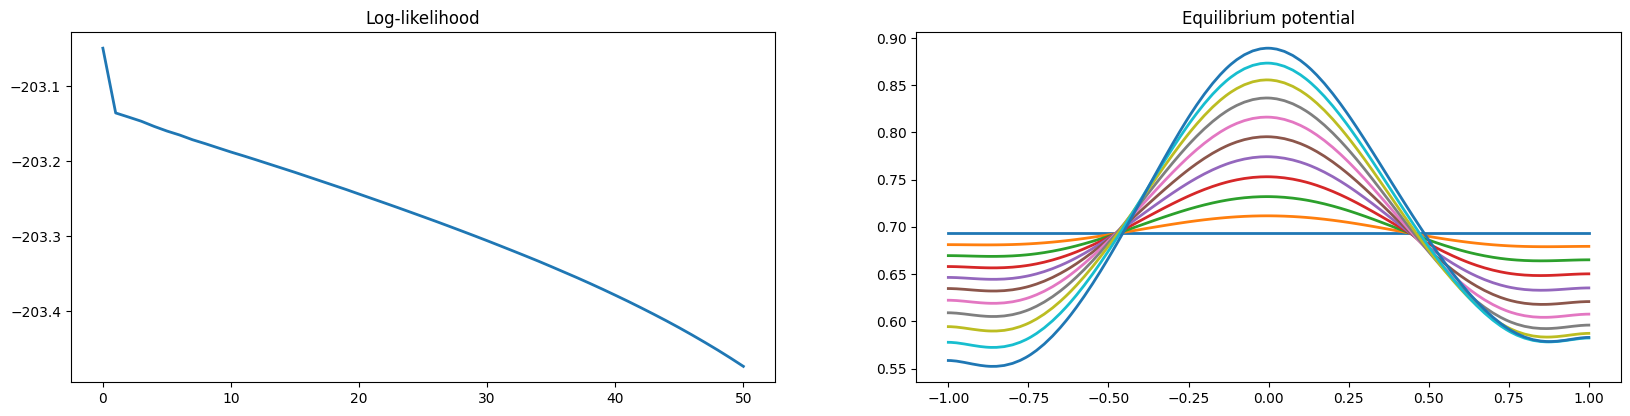

In [27]:
# here we plot the results 

# convert the Equilibrium probability to the potential
Phi1 = -np.log(optimization1.results['peq'])
print(Phi1.shape)

fig = plt.figure(figsize = (20, 10))
gs = gridspec.GridSpec(2,2)

ax = plt.subplot(gs[1, 0])
ll1 = optimization1.results['logliks']
print(ll1.shape)
iter_nums = np.array(range(ll1.size)).astype('float64')
ax.plot(iter_nums, ll1[0], linewidth = 2, label=f'Log-likelihood')
ax.set_title('Log-likelihood')

ax = plt.subplot(gs[1,1])
for i in range(0,Phi1.shape[0],5):
    ax.plot(init_model.grid.x_d, Phi1[i,0,:], linewidth = 2)
ax.set_title('Equilibrium potential')
#plt.plot(init_model.grid.x_d, Phi1[50,0,:], linewidth = 2)
plt.show()